In [ ]:
!pip install pydicom

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 8.8 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/MyDrive/imageprocessing')

In [ ]:
import os
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow import keras
import pydicom


plt.set_cmap('gray')
%matplotlib inline


seed = 2019
random.seed(seed)
np.random.seed(seed)

IMG_DTYPE = np.float64
SEG_DTYPE = np.uint8

<Figure size 640x480 with 0 Axes>

In [ ]:
def show_image(*args, **kwargs):
    cmap = kwargs.get('cmap', 'gray')
    title = kwargs.get('title', '')
    if len(args) == 0:
        raise ValueError("No images given to show_image")
    elif len(args) == 1:
        plt.title(title)
        plt.imshow(args[0], interpolation='none')
    else:
        n = len(args)
        if type(cmap) == str:
            cmap = [cmap] * n
        if type(title) == str:
            title = [title] * n
        plt.figure(figsize=(n * 5, 10))
        for i in range(n):
            plt.subplot(1, n, i + 1)
            plt.title(title[i])
            plt.imshow(args[i], cmap[i])
    plt.show()

def normalize_img(img):
    """ Normalize image values to [0,1] """
    min_val, max_val = float(np.min(img)), float(np.max(img))
    return (img - min_val) / (max_val - min_val)

In [ ]:
def preprocess_img_slice(img_slc):

    img_slc[img_slc > 1200] = 0
    img_slc = np.clip(img_slc, -100, 400)
    img_slc = normalize_img(img_slc)

    img_slc = img_slc * 255
    img_slc = img_slc.astype('uint8')
    img_slc = cv2.equalizeHist(img_slc)
    img_slc = normalize_img(img_slc)
    return img_slc

In [ ]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, ids, path, batch_size=8, image_size=128):
        self.ids = ids
        self.path = path
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()

    def load_data(self, id_name):
        patient_id = id_name.split('_')
        image_path = os.path.join(self.path, "patients", id_name)
        mask_path = os.path.join(self.path, "masks")
        all_masks = os.listdir(mask_path)
        dicom_image = pydicom.dcmread(image_path)
        image = preprocess_img_slice(dicom_image.pixel_array)
        image = normalize_img(image)
        image = np.array(Image.fromarray(image).resize([self.image_size, self.image_size])).astype(IMG_DTYPE)

        mask = pydicom.dcmread(os.path.join(mask_path, patient_id[0]+'_liver', id_name)).pixel_array
        mask = mask / 255.0
        mask = np.clip(mask, 0, 1)
        mask = np.array(Image.fromarray(mask).resize([self.image_size, self.image_size])).astype(IMG_DTYPE)
        mask = mask[:, :, np.newaxis]
        return image, mask

    def __getitem__(self, index):
        if (index + 1) * self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index * self.batch_size

        files_batch = self.ids[index * self.batch_size: (index + 1) * self.batch_size]

        images = []
        masks = []

        for id_name in files_batch:
            img, mask = self.load_data(id_name)
            img = np.stack((img,) * 3, axis=-1)
            images.append(img)
            masks.append(mask)

        images = np.array(images)
        masks = np.array(masks)

        return images, masks

    def on_epoch_end(self):
        pass

    def __len__(self):
        return int(np.ceil(len(self.ids) / float(self.batch_size)))


Error may occur here. Run again it will work. \\
You can change here how much percent data you want to run. It is 0.5 i.e. 50% here

In [ ]:
image_size = 256
train_path = "train"
batch_size = 16
epochs = 15

# Training Ids
all_images = []
for file in os.listdir(os.path.join(train_path, "patients")):
    all_images.append(file)

# Randomly select 50% of the data
selected_ids = random.sample(all_images, int(0.50 * len(all_images)))

# Divide dataset
val_data_size = len(selected_ids) // 5
validation_ids = selected_ids[:val_data_size]
training_ids = selected_ids[val_data_size:]

print(len(training_ids))

9308


In [ ]:
data_generator = DataGenerator(training_ids, train_path, batch_size=batch_size, image_size=image_size)
x_batch, y_batch = data_generator.__getitem__(0)

Our dataset is loaded. We can see liver and tumor image.

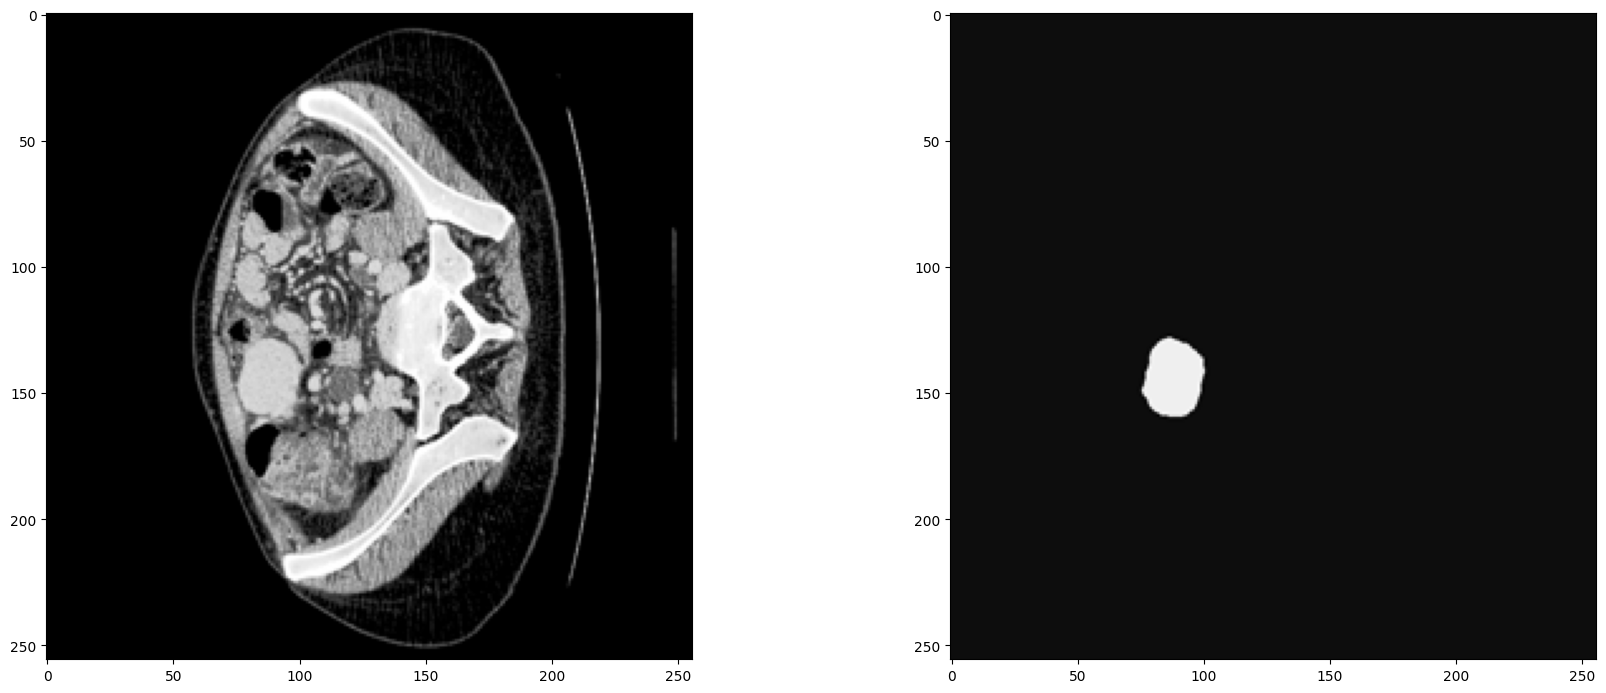

In [ ]:
random_index = random.randint(0, len(x_batch) - 1)
fig = plt.figure(figsize=(20, 20))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(x_batch[random_index])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(y_batch[random_index], (image_size, image_size)), cmap="gray")

ResUnet construction

In [ ]:
def bn_act(x, act=True):
    x = keras.layers.BatchNormalization()(x)
    if act == True:
        x = keras.layers.Activation("relu")(x)
    return x

def conv_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = bn_act(x)
    conv = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(conv)
    return conv

def stem(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    conv = conv_block(conv, filters, kernel_size=kernel_size, padding=padding, strides=strides)

    shortcut = keras.layers.Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)

    output = keras.layers.Add()([conv, shortcut])
    return output

def residual_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    res = conv_block(x, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    res = conv_block(res, filters, kernel_size=kernel_size, padding=padding, strides=1)

    shortcut = keras.layers.Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)

    output = keras.layers.Add()([shortcut, res])
    return output

def upsample_concat_block(x, xskip):
    u = keras.layers.UpSampling2D((2, 2))(x)
    c = keras.layers.Concatenate()([u, xskip])
    return c


In [ ]:
def ResUNet():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((image_size, image_size, 3))

    ## Encoder
    e0 = inputs
    e1 = stem(e0, f[0])
    e2 = residual_block(e1, f[1], strides=2)
    e3 = residual_block(e2, f[2], strides=2)
    e4 = residual_block(e3, f[3], strides=2)
    e5 = residual_block(e4, f[4], strides=2)

    ## Bridge
    b0 = conv_block(e5, f[4], strides=1)
    b1 = conv_block(b0, f[4], strides=1)

    ## Decoder
    u1 = upsample_concat_block(b1, e4)
    d1 = residual_block(u1, f[4])

    u2 = upsample_concat_block(d1, e3)
    d2 = residual_block(u2, f[3])

    u3 = upsample_concat_block(d2, e2)
    d3 = residual_block(u3, f[2])

    u4 = upsample_concat_block(d3, e1)
    d4 = residual_block(u4, f[1])

    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(d4)
    model = keras.models.Model(inputs, outputs)
    return model


In [ ]:
smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [ ]:
model = ResUNet()
adam = keras.optimizers.Adam()
model.compile(optimizer=adam, loss=dice_coef_loss, metrics=["acc", dice_coef])
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         448       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 16)         64        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 256, 256, 16)         0         ['batch_normalization[0][0

In [ ]:
train_data_generator = DataGenerator(training_ids, train_path, image_size=image_size, batch_size=batch_size)
valid_data_generator = DataGenerator(validation_ids, train_path, image_size=image_size, batch_size=batch_size)

train_steps = len(training_ids) // batch_size
valid_steps = len(validation_ids) // batch_size


In [ ]:

# # Check GPU utilization
# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("No GPU detected. Training on CPU.")

Default GPU Device: /device:GPU:0


In [ ]:
# model.fit(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, epochs=epochs)
# Train the model using GPU if available
with tf.device('/device:GPU:0'):
    model.fit(train_data_generator, validation_data=valid_data_generator, steps_per_epoch=train_steps, validation_steps=valid_steps, epochs=epochs)

Epoch 1/15
581/581 [==============================] - 4124s 7s/step - loss: 0.1457 - acc: 0.9492 - dice_coef: 0.8569 - val_loss: 0.9785 - val_acc: 0.9031 - val_dice_coef: 0.0215
Epoch 2/15
581/581 [==============================] - 654s 1s/step - loss: 0.1226 - acc: 0.9538 - dice_coef: 0.8773 - val_loss: 0.9231 - val_acc: 0.9094 - val_dice_coef: 0.0769
Epoch 3/15
581/581 [==============================] - 447s 769ms/step - loss: 0.1175 - acc: 0.9541 - dice_coef: 0.8770 - val_loss: 0.8635 - val_acc: 0.9119 - val_dice_coef: 0.1365
Epoch 4/15
581/581 [==============================] - 262s 451ms/step - loss: 0.1330 - acc: 0.9538 - dice_coef: 0.8670 - val_loss: 0.2042 - val_acc: 0.9424 - val_dice_coef: 0.7958
Epoch 5/15
581/581 [==============================] - 229s 395ms/step - loss: 0.1200 - acc: 0.9549 - dice_coef: 0.8800 - val_loss: 0.1201 - val_acc: 0.9546 - val_dice_coef: 0.8799
Epoch 6/15
581/581 [==============================] - 197s 339ms/step - loss: 0.1280 - acc: 0.9543 - dice

In [ ]:
# model.save(os.path.join('models', 'liver_segmentation_model_50percent.h5'))  # creates a HDF5 file 'liver_model_final_resunet.h5'


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model.save('liver_segmentation_model.h5')
# model.save_weights("liver_segmenatation_weights_5opercent.h5")